# <center> PORTO SEGURO'S SAFE DRIVER PREDICTION

## Overview

Nothing ruins the thrill of buying a brand new car more quickly than seeing your new insurance bill. The sting’s even more painful when you know you’re a good driver. It doesn’t seem fair that you have to pay so much if you’ve been cautious on the road for years.

Porto Seguro, one of Brazil’s largest auto and homeowner insurance companies, completely agrees. Inaccuracies in car insurance company’s claim predictions raise the cost of insurance for good drivers and reduce the price for bad ones.

In this problem, you’re challenged to build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year.

## Scoring Metric

Submissions are evaluated using the Normalized Gini Coefficient.

During scoring, observations are sorted from the largest to the smallest predictions. Predictions are only used for ordering observations; therefore, the relative magnitude of the predictions are not used during scoring. The scoring algorithm then compares the cumulative proportion of positive class observations to a theoretical uniform proportion.

The Gini Coefficient ranges from approximately 0 for random guessing, to approximately 0.5 for a perfect score. The theoretical maximum for the discrete calculation is (1 - frac_pos) / 2.

The Normalized Gini Coefficient adjusts the score by the theoretical maximum so that the maximum score is 1.

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 
import xgboost as xgb
from sklearn.metrics import  roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
from lightgbm import LGBMClassifier

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
X = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
test_id = test['id']
test.drop('id', axis=1, inplace=True)
y = X['target']
train = X.drop(['id','target'], axis=1)

In [4]:
train.head()

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


In [5]:
train.shape, test.shape 

((595212, 57), (892816, 57))

In [6]:
# Code for calculating Normalized gini coefficient
# https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703
def gini(actual, pred, cmpcol = 0, sortcol = 1):  
    assert( len(actual) == len(pred) )  
    all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)  
    all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]  
    totalLosses = all[:,0].sum()  
    giniSum = all[:,0].cumsum().sum() / totalLosses  
  
    giniSum -= (len(actual) + 1) / 2  
    return giniSum / len(actual)  
  
def gini_normalized(a, p):  
    '''Function to calculate the normalized gini coefficient'''
    return gini(a, p) / gini(a, a) 

In [7]:
def missing_values(data):
    '''Function to find the percentage of missing values in each column of a DataFrame passed'''
    for i in data.columns.values:
        count =  data[data[i] == -1].shape[0]
        print("Missing Values in '{}' : {:.4f} %".format(i, (count/data.shape[0])*100))

In [8]:
def filling_missing_values(data):
    '''A function to fill in the missing values of categorical features'''
    for i in tqdm(data.columns.values):
        if data[data[i] == -1].shape[0] > 0:
            if i == 'ps_car_03_cat' or i == 'ps_car_05_cat':
                continue
            elif i == 'ps_ind_05_cat' or i == 'ps_car_07_cat':
                lst = data[i].apply(lambda x:data[i].mode() if x == -1 else x)
                data[i] = pd.Series(lst)
            else:
                lst = data[i].apply(lambda x:data[i].mean() if x == -1 else x)
                data[i] = pd.Series(lst)
        else:
            continue
    return data

In [9]:
def one_hot_encoding(train, test, cat_features):
    '''Function to one-hot-encode categorical features'''
    temp = pd.concat([train, test])
    temp = pd.get_dummies(temp, columns = cat_features)
    train = temp.iloc[:train.shape[0],:]
    test = temp.iloc[train.shape[0]:, :]
    return train, test

In [10]:
def target_encoding(train, test, target, cat_features):
    '''Function to target encode categorical data'''
    prior = target.mean()
   # features = train.columns.values
    train['target'] = target
    
    def smooth(x, mean, count, prior, smoothing=1, min_samples_leaf = 1):
        smoothing = 1 / (1 + np.exp(-(count - min_samples_leaf) / smoothing))
        return (prior * (1 - smoothing) + mean * smoothing)
   
    for i in cat_features:
        
        v = train.groupby(i)['target'].agg(['mean','count'])
        
        train[i] = train[i].apply(lambda x : smooth(x, v['mean'][x], v['count'][x], prior))
        test[i] = test[i].apply(lambda x : smooth(x, v['mean'][x], v['count'][x], prior)) 
            
    train.drop(['target'], axis=1, inplace = True)
        
    return train, test

In [11]:
def label_encoding(train, test, cat_features):
    '''Function to label encode categorical variables'''
    for i in cat_features:
        le = LabelEncoder()
        le.fit(train[i])
        train[i] = le.transform(train[i])
        test[i] = le.transform(test[i])
    return train, test

In [12]:
def freq_encoding(train, test, cat_features):
    '''Function to frequency encode categorical variables'''
    for i in cat_features:
        vc = train[i].value_counts()
        train[i] = train[i].apply(lambda x: vc[x])
        test[i] = test[i].apply(lambda x: vc[x])
    return train, test

# <center>Exploratory Data Analysis

In [13]:
imbalance = y.value_counts()
print("Percent of Insurance Claimed(Class 1) : ", (imbalance[1]/train.shape[0])*100)
print("Percent of Insurance Not Claimed(Class 0) : ", (imbalance[0]/train.shape[0])*100)

Percent of Insurance Claimed(Class 1) :  3.6447517859182947
Percent of Insurance Not Claimed(Class 0) :  96.3552482140817


1. There are a total of 57 features in the dataset all of which are anonymized. The feature names indicate what kind of features they are: <br>
   <p> a. Feature with 'bin' represents a binary feature.<br>
    b. Feature with 'cat' represents a categorical feature.<br>
    c. Feature with 'calc' represents a  extra calculated feature.<br>
    d. Rest are continuous.
 </p>
    
2. The dataset is highly imbalanced(96:4)

3. The data contains a few -1 values which corresponds to the missing values in the dataset


In [14]:
all_features = train.columns.values
cat_features = []
for i in train.columns.values:
    if i.endswith('cat'):
        cat_features.append(i)
    else:
        continue

bin_features = []
for i in train.columns.values:
    if i.endswith('bin'):
        bin_features.append(i)
    else:
        continue

calc_features = []
for i in train.columns.values:
    if i.startswith('ps_calc'):
        calc_features.append(i)
    else:
        continue

calc_bin_features = []
for i in calc_features:
    if i.endswith('bin'):
        calc_bin_features.append(i)
    else:
        continue

calc_num_features = list(set(calc_features) - set(calc_bin_features))
num_features_with_calc = list((set(train.columns.values) - set(cat_features)) - set(bin_features))
num_features_wo_calc = list(set(num_features_with_calc) - set(calc_features))

## Binary Features

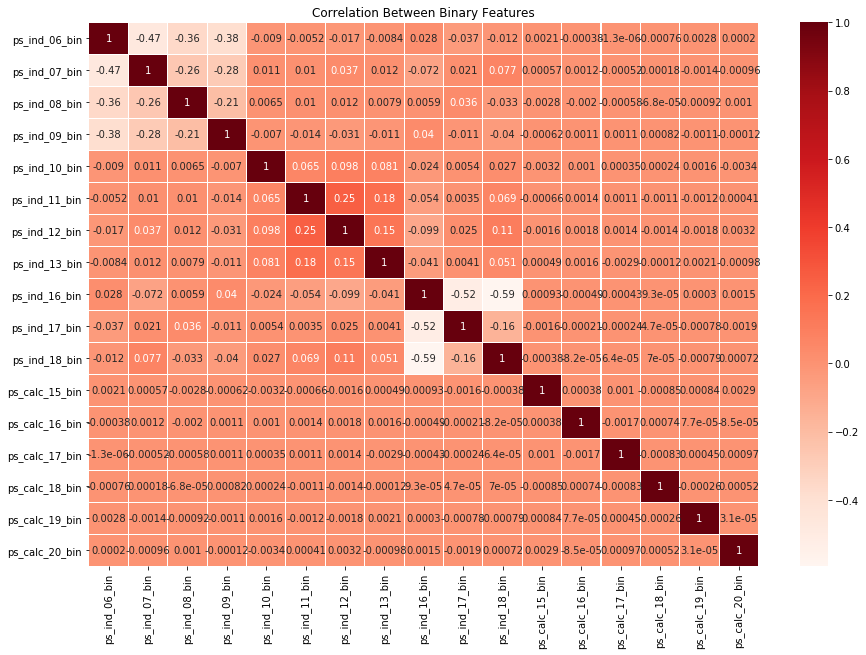

In [15]:
plt.figure(figsize=(15,10))
plt.title("Correlation Between Binary Features")
sns.heatmap(train[bin_features].corr(), cmap='Reds', annot = True, linewidths=0.01)

The binary features dont have any noticeable correlation between them. 'ps_ind_18_bin' and 'ps_ind_16_bin' have the largest negative correlation but nothing of great concern.

In [16]:
missing_values(train[bin_features])

Missing Values in 'ps_ind_06_bin' : 0.0000 %
Missing Values in 'ps_ind_07_bin' : 0.0000 %
Missing Values in 'ps_ind_08_bin' : 0.0000 %
Missing Values in 'ps_ind_09_bin' : 0.0000 %
Missing Values in 'ps_ind_10_bin' : 0.0000 %
Missing Values in 'ps_ind_11_bin' : 0.0000 %
Missing Values in 'ps_ind_12_bin' : 0.0000 %
Missing Values in 'ps_ind_13_bin' : 0.0000 %
Missing Values in 'ps_ind_16_bin' : 0.0000 %
Missing Values in 'ps_ind_17_bin' : 0.0000 %
Missing Values in 'ps_ind_18_bin' : 0.0000 %
Missing Values in 'ps_calc_15_bin' : 0.0000 %
Missing Values in 'ps_calc_16_bin' : 0.0000 %
Missing Values in 'ps_calc_17_bin' : 0.0000 %
Missing Values in 'ps_calc_18_bin' : 0.0000 %
Missing Values in 'ps_calc_19_bin' : 0.0000 %
Missing Values in 'ps_calc_20_bin' : 0.0000 %


The binary features do not contain any missing values

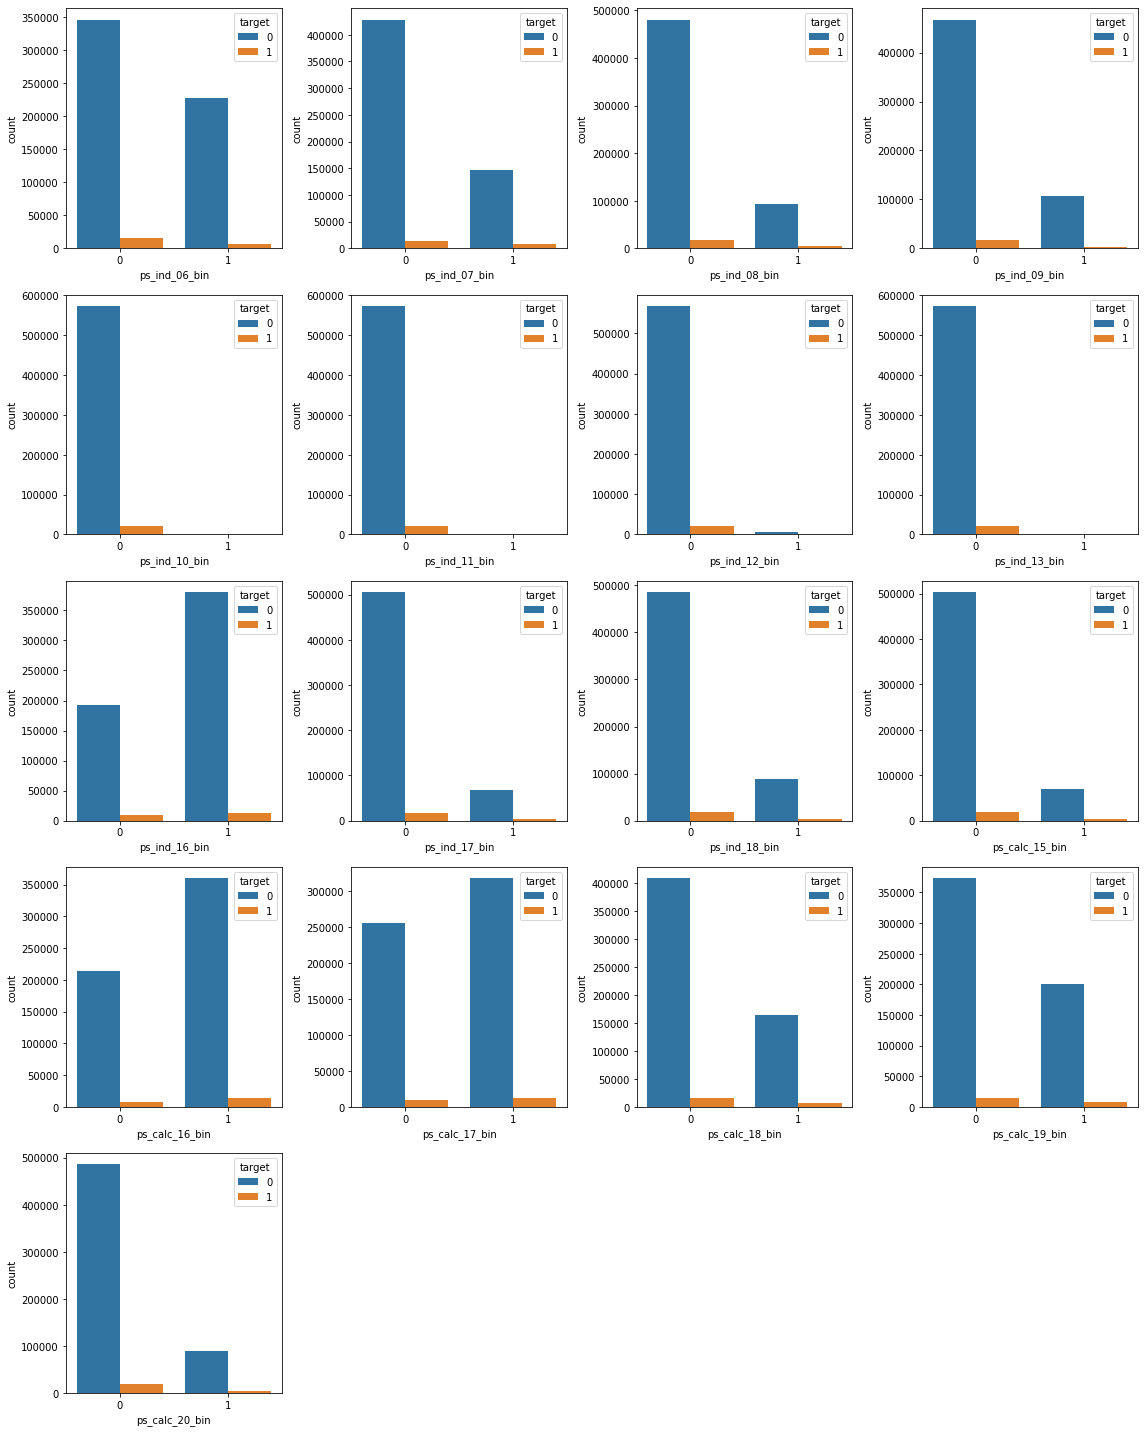

In [17]:
plt.figure(figsize=(16,20))
plt.title("Count Plots of Binary Features")
for i in range(len(bin_features)):
    plt.subplot(5,4,i+1)
    plt.ylabel('Count')
    sns.countplot(train[bin_features[i]], hue=y)
    plt.tight_layout()

1. Apart from a few calc features most of the binary features are dominated by a single value.
2. Some binary features like 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin' do not account for the positive class at all whereas for most of the calc features 0s and 1s account almost equally for both positive and negative class.

## Categorical Features

In [18]:
for i in cat_features:
    cardinality = len(list(train[i].unique()))
    print("Cardinality of '{}' : {}".format(i, cardinality))

Cardinality of 'ps_ind_02_cat' : 5
Cardinality of 'ps_ind_04_cat' : 3
Cardinality of 'ps_ind_05_cat' : 8
Cardinality of 'ps_car_01_cat' : 13
Cardinality of 'ps_car_02_cat' : 3
Cardinality of 'ps_car_03_cat' : 3
Cardinality of 'ps_car_04_cat' : 10
Cardinality of 'ps_car_05_cat' : 3
Cardinality of 'ps_car_06_cat' : 18
Cardinality of 'ps_car_07_cat' : 3
Cardinality of 'ps_car_08_cat' : 2
Cardinality of 'ps_car_09_cat' : 6
Cardinality of 'ps_car_10_cat' : 3
Cardinality of 'ps_car_11_cat' : 104


Feature 'ps_car_11_cat' stands out in the categorical features since it has the highest cardinality. Rest all the features have relatively low cardinality.

In [19]:
missing_values(train[cat_features])

Missing Values in 'ps_ind_02_cat' : 0.0363 %
Missing Values in 'ps_ind_04_cat' : 0.0139 %
Missing Values in 'ps_ind_05_cat' : 0.9760 %
Missing Values in 'ps_car_01_cat' : 0.0180 %
Missing Values in 'ps_car_02_cat' : 0.0008 %
Missing Values in 'ps_car_03_cat' : 69.0898 %
Missing Values in 'ps_car_04_cat' : 0.0000 %
Missing Values in 'ps_car_05_cat' : 44.7825 %
Missing Values in 'ps_car_06_cat' : 0.0000 %
Missing Values in 'ps_car_07_cat' : 1.9302 %
Missing Values in 'ps_car_08_cat' : 0.0000 %
Missing Values in 'ps_car_09_cat' : 0.0956 %
Missing Values in 'ps_car_10_cat' : 0.0000 %
Missing Values in 'ps_car_11_cat' : 0.0000 %


1. The cat_features contains some missing values. 
2. A large portion of the features 'ps_car_03_cat' and 'ps_car_05_cat' consists of missing values. For these features instead of filling the missing values, they can be considered as a separate category.

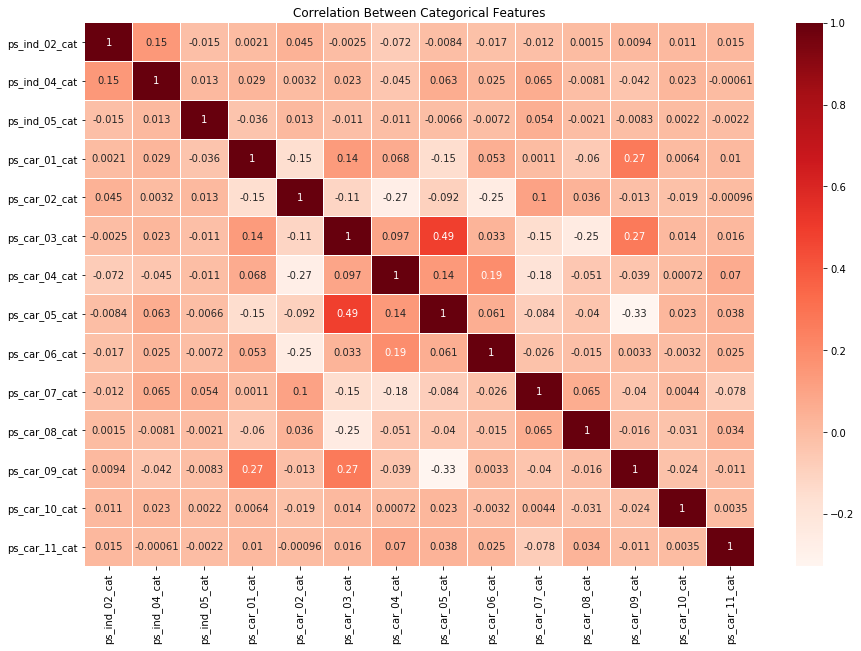

In [20]:
plt.figure(figsize=(15,10))
plt.title("Correlation Between Categorical Features")
sns.heatmap(train[cat_features].corr(), cmap='Reds', annot = True, linewidths=0.01)

Even categorical features dont have any noticeable correlation between them.

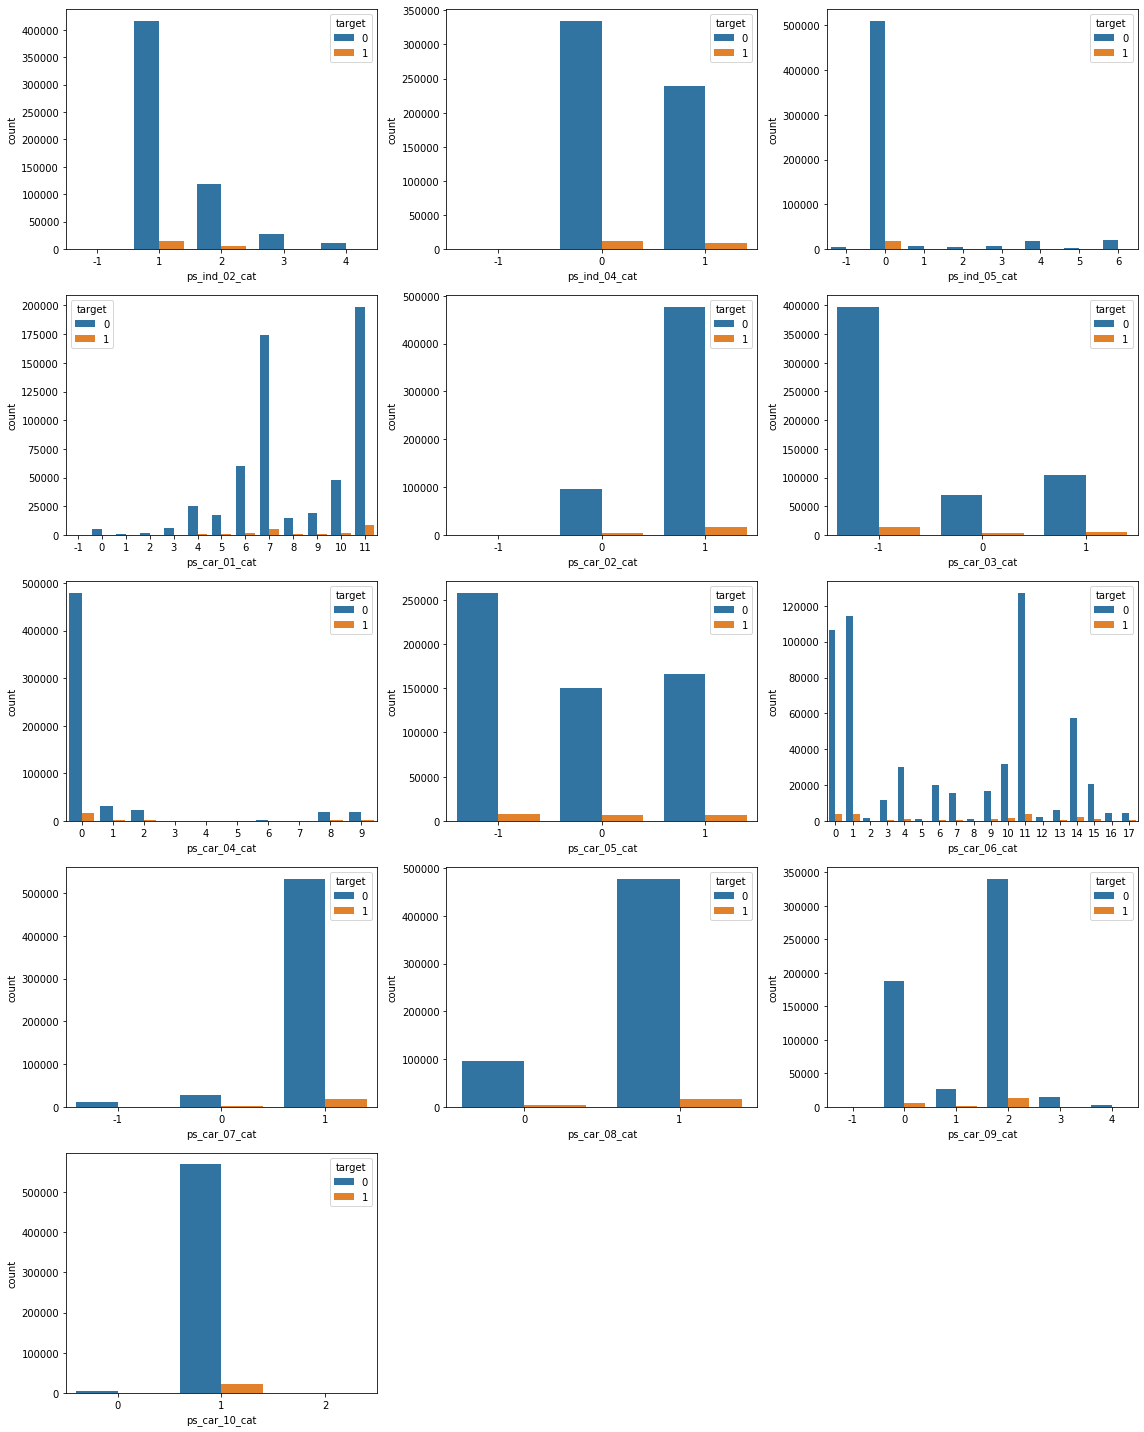

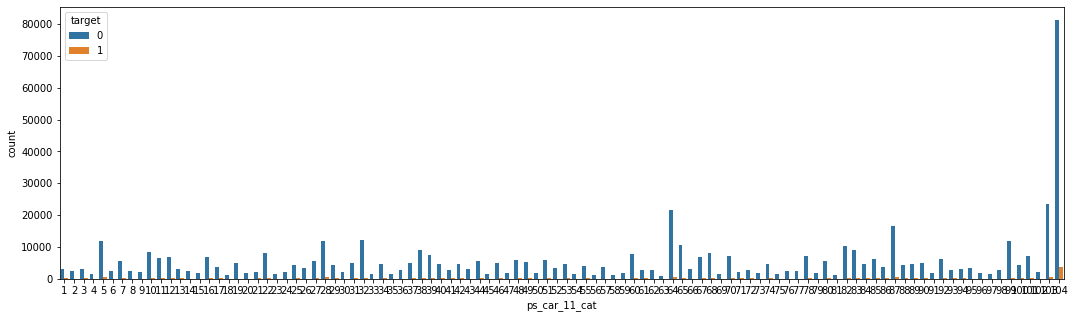

In [21]:
plt.figure(figsize=(16,20))
plt.title("Count Plots of Categorical Features")
for i in range(len(cat_features)-1):
    plt.subplot(5,3,i+1)
    sns.countplot(train[cat_features[i]], hue=y)
    plt.tight_layout()
plt.figure(figsize=(18,5))
sns.countplot(train['ps_car_11_cat'], hue=y)

1. Some features like 'ps_ind_05_cat' and 'ps_car_04_cat' mostly consists of a single value. Therefore the mode of these features can be used for filling their missing values.
2. The missing values of each of the categorical features can be filled in the following way:<br>

     1. ps_ind_02_cat   ---> mean 
     2. ps_ind_04_cat   ---> mean  
     3. ps_ind_05_cat   ---> mode
     4. ps_car_01_cat   ---> mean
     5. ps_car_02_cat   ---> mean
     6. ps_car_03_cat   ---> can be considered as a separate category
     7. ps_car_05_cat   ---> can be considered as a separate category
     8. ps_car_07_cat   ---> mode
     9. ps_car_09_cat   ---> mean
     
3. Different encoding methods like OHE, target encoding, label encoding can be tried for these features.

## Continuous Features

Continuous features can be separated into calc and the rest. Both of them can be looked separately.

In [22]:
train[num_features_with_calc].describe()

,ps_ind_14,ps_calc_02,ps_car_13,ps_calc_05,ps_calc_10,ps_calc_09,ps_calc_01,ps_reg_02,ps_car_12,ps_calc_08,ps_calc_06,ps_calc_04,ps_calc_14,ps_reg_01,ps_calc_11,ps_ind_03,ps_car_14,ps_car_15,ps_car_11,ps_reg_03,ps_ind_15,ps_ind_01,ps_calc_07,ps_calc_03,ps_calc_12,ps_calc_13
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.012451,0.449589,0.813265,1.885886,8.433590,2.339034,0.449756,0.439184,0.379945,9.225904,7.689445,2.372081,7.539026,0.610991,5.441382,4.423318,0.276256,3.065899,2.346072,0.551102,7.299922,1.900378,3.005823,0.449849,1.441918,2.872288
std,0.127545,0.286893,0.224588,1.134927,2.904597,1.246949,0.287198,0.404264,0.058327,1.459672,1.334312,1.117219,2.746652,0.287643,2.332871,2.699902,0.357154,0.731366,0.832548,0.793506,3.546042,1.983789,1.414564,0.287153,1.202963,1.694887
min,0.000000,0.000000,0.250619,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.200000,0.670867,1.000000,6.000000,1.000000,0.200000,0.200000,0.316228,8.000000,7.000000,2.000000,6.000000,0.400000,4.000000,2.000000,0.333167,2.828427,2.000000,0.525000,5.000000,0.000000,2.000000,0.200000,1.000000,2.000000
50%,0.000000,0.400000,0.765811,2.000000,8.000000,2.000000,0.500000,0.300000,0.374166,9.000000,8.000000,2.000000,7.000000,0.700000,5.000000,4.000000,0.368782,3.316625,3.000000,0.720677,7.000000,1.000000,3.000000,0.500000,1.000000,3.000000
75%,0.000000,0.700000,0.906190,3.000000,10.000000,3.000000,0.700000,0.600000,0.400000,10.000000,9.000000,3.000000,9.000000,0.900000,7.000000,6.000000,0.396485,3.605551,3.000000,1.000000,10.000000,3.000000,4.000000,0.700000,2.000000,4.000000
max,4.000000,0.900000,3.720626,6.000000,25.000000,7.000000,0.900000,1.800000,1.264911,12.000000,10.000000,5.000000,23.000000,0.900000,19.000000,11.000000,0.636396,3.741657,3.000000,4.037945,13.000000,7.000000,9.000000,0.900000,10.000000,13.000000


In [23]:
missing_values(train[num_features_wo_calc])

Missing Values in 'ps_ind_14' : 0.0000 %
Missing Values in 'ps_reg_03' : 18.1065 %
Missing Values in 'ps_reg_01' : 0.0000 %
Missing Values in 'ps_car_13' : 0.0000 %
Missing Values in 'ps_ind_15' : 0.0000 %
Missing Values in 'ps_car_15' : 0.0000 %
Missing Values in 'ps_ind_01' : 0.0000 %
Missing Values in 'ps_ind_03' : 0.0000 %
Missing Values in 'ps_car_14' : 7.1605 %
Missing Values in 'ps_reg_02' : 0.0000 %
Missing Values in 'ps_car_12' : 0.0002 %
Missing Values in 'ps_car_11' : 0.0008 %


In [24]:
missing_values(train[calc_num_features])

Missing Values in 'ps_calc_02' : 0.0000 %
Missing Values in 'ps_calc_04' : 0.0000 %
Missing Values in 'ps_calc_14' : 0.0000 %
Missing Values in 'ps_calc_11' : 0.0000 %
Missing Values in 'ps_calc_01' : 0.0000 %
Missing Values in 'ps_calc_05' : 0.0000 %
Missing Values in 'ps_calc_12' : 0.0000 %
Missing Values in 'ps_calc_07' : 0.0000 %
Missing Values in 'ps_calc_03' : 0.0000 %
Missing Values in 'ps_calc_10' : 0.0000 %
Missing Values in 'ps_calc_08' : 0.0000 %
Missing Values in 'ps_calc_09' : 0.0000 %
Missing Values in 'ps_calc_13' : 0.0000 %
Missing Values in 'ps_calc_06' : 0.0000 %


#### Distplots of continuous features excluding calc features

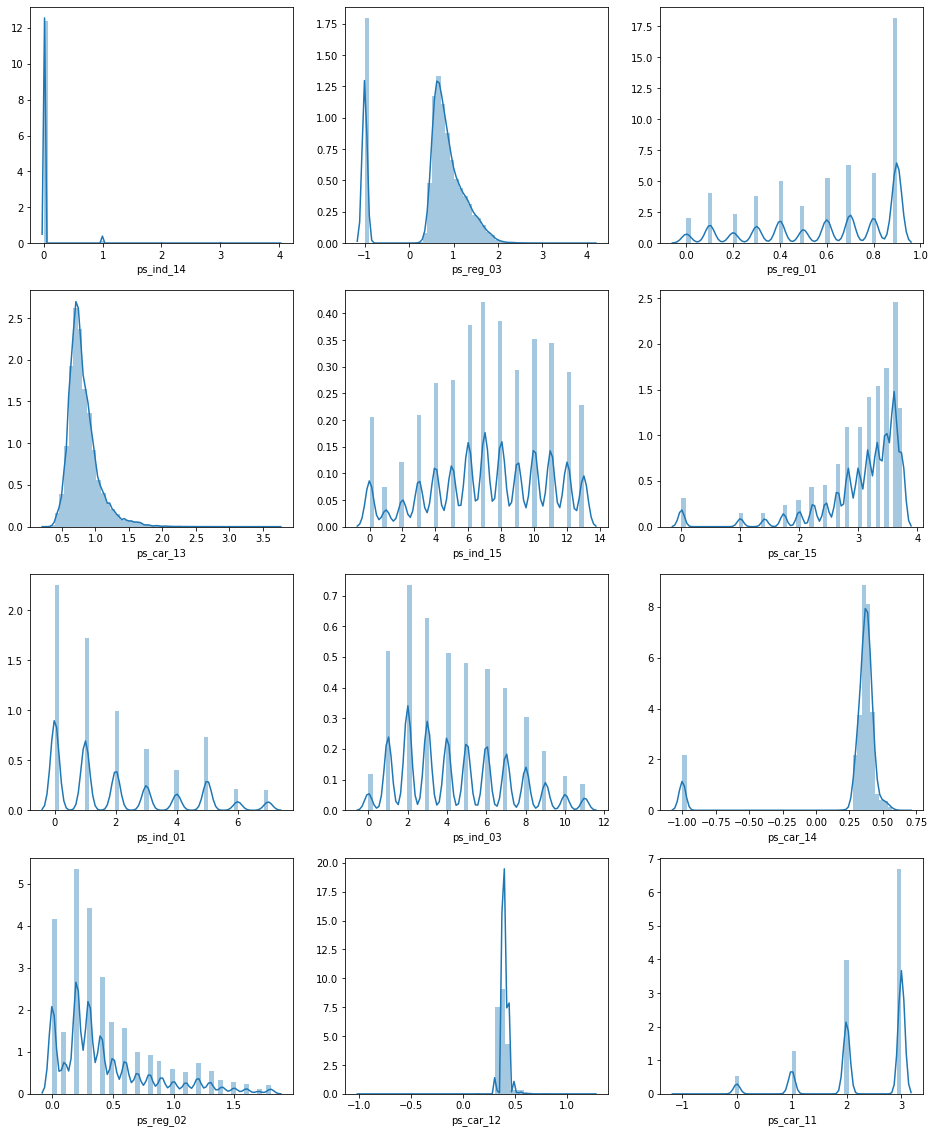

In [25]:
plt.figure(figsize=(16,20))
for i in range(len(num_features_wo_calc)):
    plt.subplot(4,3,i+1)
    sns.distplot(train[num_features_wo_calc[i]])

1. Most of the features like 'ps_reg_01', 'ps_car_11' etc contains few unique values.
2. Features like 'ps_reg_01', 'ps_car_11' and 'ps_ind_14' is dominated by a single value.

#### Boxplots of continuous features excluding calc features

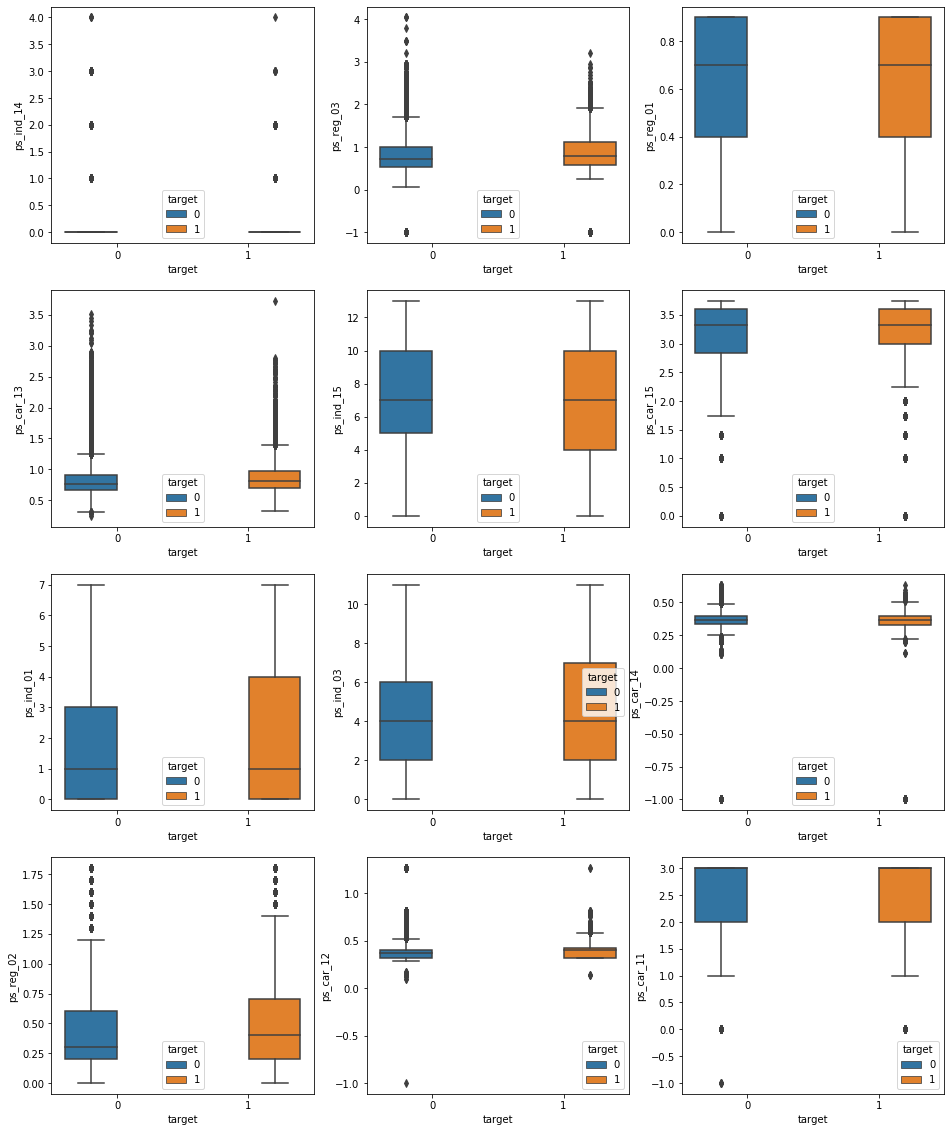

In [26]:
plt.figure(figsize=(16,20))
for i in range(len(num_features_wo_calc)):
    plt.subplot(4,3,i+1)
    sns.boxplot(y, train[num_features_wo_calc[i]], hue=y)

1. The boxplots shows the separabilty of each feature with the class labels. Although the features doesnt seem to exhibit high varying patterns for the two classes, there are small differences in skewness and mean that could help in separating both classes.
2. For example features like 'ps_ind_01', 'ps_reg_02', 'ps_ind_03','ps_car_13' all have different skews and distribution of data for both classes. Those features could prove valuable in determining the final result.
3. 'ps_reg_02' in particular has a noticeable difference in mean and distribution for both classes.

#### Distplots of calc features

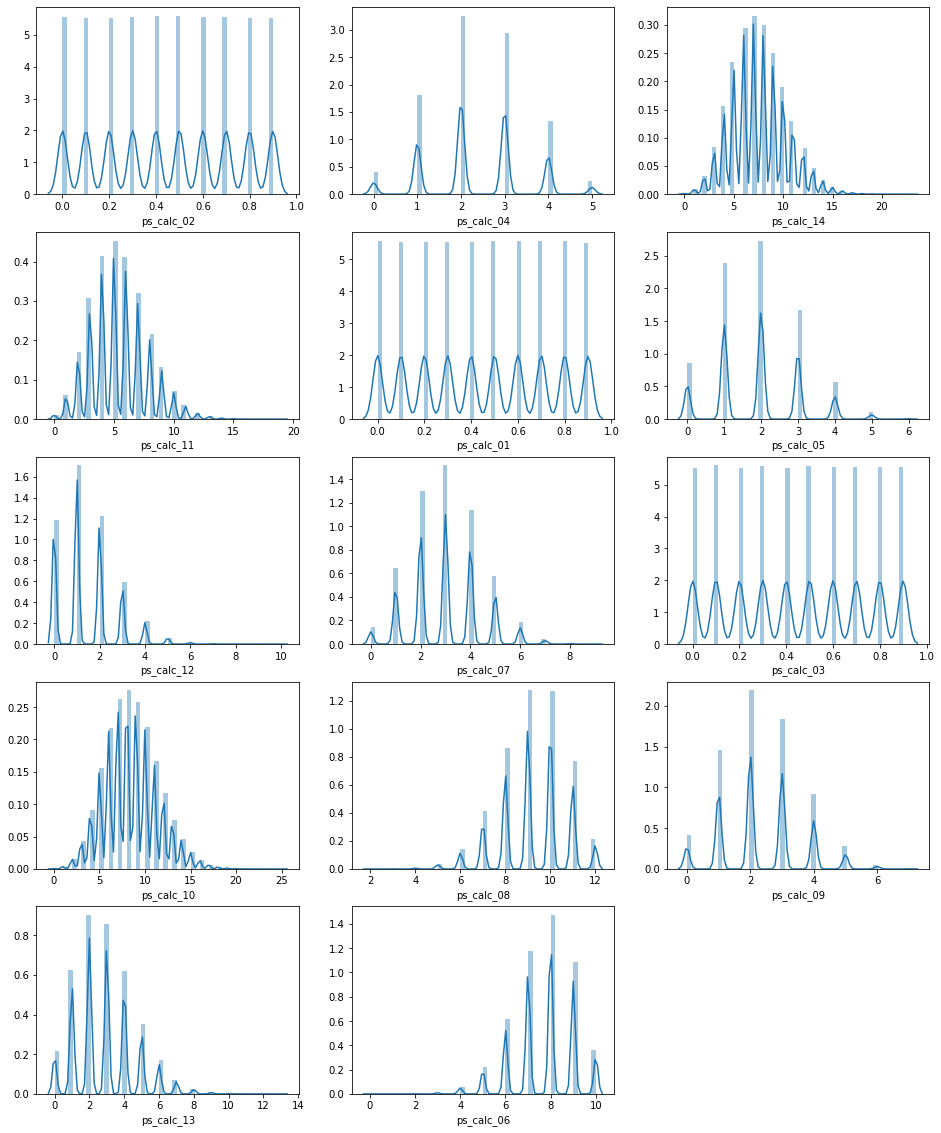

In [27]:
plt.figure(figsize=(16,20))
for i in range(len(calc_num_features)):
    plt.subplot(5,3,i+1)
    sns.distplot(train[calc_num_features[i]])

1. Features 'ps_calc_03','ps_calc_01', 'ps_calc_02' are uniformly distributed.
2. Some other features like 'ps_calc_07', 'ps_calc_14', 'ps_calc_11', 'ps_calc_10' seems to be gaussian distributed.

#### Boxplots of calculated continuous features

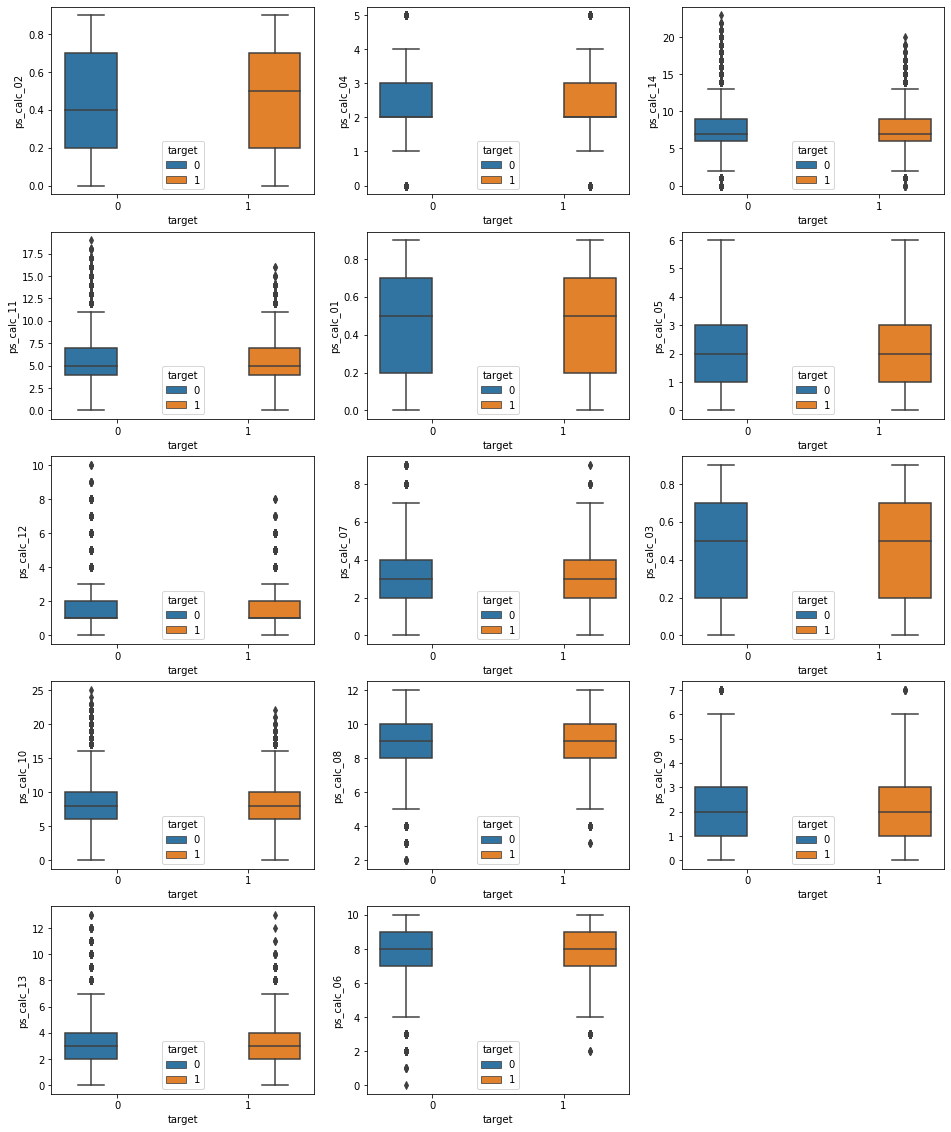

In [28]:
plt.figure(figsize=(16,20))
for i in range(len(calc_num_features)):
    plt.subplot(5,3,i+1)
    sns.boxplot(y, train[calc_num_features[i]], hue=y)

1. Apart from 'ps_calc_02' there is no difference between the two class distributions in any of the calc features. There is no valuable info provided by any of the calc features.
2. As suggested in the kaggle discussions as well, these features do not prove to give any information towards the prediction.

In [29]:
#train_without_mv = filling_missing_values(train)
#test_without_mv = filling_missing_values(test)

In [30]:
train_without_mv = pd.read_csv('train_without_mv.csv')
test_without_mv = pd.read_csv('test_without_mv.csv')

An extra feature missing is added to the dataset which consists of all the missing values in a row.

In [31]:
train_without_mv['missing'] = (train == -1).sum(axis=1)
test_without_mv['missing'] = (test == -1).sum(axis=1)

In [32]:
print("Shape of New Train without any missing values and with 'missing' :", train_without_mv.shape)
print("Shape of New Test without any missing values and with 'missing' :", test_without_mv.shape)

Shape of New Train without any missing values and with 'missing' : (595212, 58)
Shape of New Test without any missing values and with 'missing' : (892816, 58)


In [33]:
# dropping all calc features since they proved to be just random noise
train_without_mv.drop(calc_features, axis=1, inplace=True)
test_without_mv.drop(calc_features, axis=1, inplace=True)

In [34]:
print("Final Train Shape :", train_without_mv.shape)
print("Final Test Shape :", test_without_mv.shape)

Final Train Shape : (595212, 38)
Final Test Shape : (892816, 38)


# <center> Modelling

In [35]:
# These are for the actual submission
train_ohe, test_ohe = one_hot_encoding(train_without_mv, test_without_mv, cat_features)

In [36]:
# dividing the train dataset for cross validation and one_hot_encoding categorical features
# These are for finding the best model
X_train, X_cv, y_train, y_cv = train_test_split(train_without_mv, y, test_size = 0.2, stratify = y, random_state = 2019)
X_train, X_cv = one_hot_encoding(X_train, X_cv, cat_features) 

In [37]:
scaler = StandardScaler()
scaler.fit(X_train[num_features_wo_calc])

X_train[num_features_wo_calc] = scaler.transform(X_train[num_features_wo_calc])
X_cv[num_features_wo_calc] = scaler.transform(X_cv[num_features_wo_calc])

In [38]:
print("X_train Shape : ", X_train.shape)
print("X_cv Shape : ", X_cv.shape)

X_train Shape :  (476169, 207)
X_cv Shape :  (119043, 207)


## Logistic Regression

In [39]:
alpha = [0.0001,0.001,0.01,0.03]
auc_lr1 = {}
gini_lr1 = {}
for i in alpha:
    lr = SGDClassifier(loss='log', alpha=i, n_jobs=-1)
    lr.fit(X_train, y_train)
    
    auc_lr1[i] = roc_auc_score(y_cv, lr.predict_proba(X_cv)[:,1])
    gini_lr1[i] = gini_normalized(y_cv, lr.predict_proba(X_cv)[:,1])

In [40]:
h = max(gini_lr1, key=auc_lr1.get)
print('Best Gini:', gini_lr1[h])
print('Best AUC:', auc_lr1[h])
print('Best Parameters:', h)

Best Gini: 0.265320767429328
Best AUC: 0.632660383714664
Best Parameters: 0.001


In [41]:
auc_lr2 = {}
gini_lr2 = {}
alpha = [0.0001,0.001,0.01,0.03]
for i in alpha:
    lr = SGDClassifier(loss='log', alpha=i, penalty = 'l1', n_jobs=-1)
    lr.fit(X_train, y_train)
    
    auc_lr2[i] = roc_auc_score(y_cv, lr.predict_proba(X_cv)[:,1])
    gini_lr2[i] = gini_normalized(y_cv, lr.predict_proba(X_cv)[:,1])

In [42]:
h = max(gini_lr2, key=auc_lr2.get)
print('Best Gini:', gini_lr2[h])
print('Best AUC:', auc_lr2[h])
print('Best Parameters:', h)

Best Gini: 0.25232306706061497
Best AUC: 0.6261615335303075
Best Parameters: 0.0001


Logistic Regression does not seem to produce a good result for this problem

## SVM

In [43]:
alpha = [0.0001,0.001,0.01,0.03]
auc_svm1 = {}
gini_svm1 = {}
for i in alpha:
    svm = SGDClassifier(alpha=i, n_jobs=-1)
    calib = CalibratedClassifierCV(svm, cv=3)
    calib.fit(X_train, y_train)
    
    auc_svm1[i] = roc_auc_score(y_cv, calib.predict_proba(X_cv)[:,1])
    gini_svm1[i] = gini_normalized(y_cv, calib.predict_proba(X_cv)[:,1])

In [44]:
h = max(gini_svm1, key=auc_svm1.get)
print('Best Gini:', gini_svm1[h])
print('Best AUC:', auc_svm1[h])
print('Best Parameters:', h)

Best Gini: 0.12195543499544824
Best AUC: 0.5609777174977242
Best Parameters: 0.001


## RandomForest

In [45]:
n_est = [1000,1200,1300,1400]
min_samples_leaf = [1000,1100,1200,1300]
auc_rf1 = {}
gini_rf1 = {}
for i in n_est:
    for j in min_samples_leaf:
        rf = RandomForestClassifier(n_estimators=i, min_samples_leaf=j, n_jobs=-1)
        rf.fit(X_train, y_train)
        
        auc_rf1[(i,j)] = roc_auc_score(y_cv, rf.predict_proba(X_cv)[:,1])
        gini_rf1[(i,j)] = gini_normalized(y_cv, rf.predict_proba(X_cv)[:,1])

In [46]:
h = max(gini_rf1, key=auc_rf1.get)
print('Best Gini:', gini_rf1[h])
print('Best AUC:', auc_rf1[h])
print('Best Parameters:', h)

Best Gini: 0.265771849816489
Best AUC: 0.6328859249082445
Best Parameters: (1000, 1000)


In [47]:
max_leaf_nodes = [90,100,120,150]
auc_rf2 = {}
gini_rf2 = {}
for i in max_leaf_nodes:
    rf = RandomForestClassifier(n_estimators=1200, min_samples_leaf=1000, max_leaf_nodes=i, n_jobs=-1)
    rf.fit(X_train, y_train)

    auc_rf2[(i,j)] = roc_auc_score(y_cv, rf.predict_proba(X_cv)[:,1])
    gini_rf2[(i,j)] = gini_normalized(y_cv, rf.predict_proba(X_cv)[:,1])

In [48]:
h = max(gini_rf2, key=auc_rf2.get)
print('Best Gini:', gini_rf2[h])
print('Best AUC:', auc_rf2[h])
print('Best Parameters:', h)

Best Gini: 0.26564194844059036
Best AUC: 0.6328209742202953
Best Parameters: (150, 1300)


Even SVMs or RandomForests are not proving to be fruitful

## XGBoost Parameter Tuning

1. Xgboost wasn't used much in the competition but with proper parameter tuning, the results were good and later proved to be a valuable addition to the stack.
2. Gridsearch and RandomSearch wasn't used because of the computational overhead and the manual tuning gave more insight on how the model performed with small changes in the parameters.

In [49]:
n_estimators1 = [700,900,1200,1300]
learning_rate = [0.01,0.1,0.3]
auc_xgb1 = {}
gini_xgb1 = {}
for i in n_estimators1:
    for j in learning_rate:
        xgb_model = xgb.XGBClassifier(n_estimators = i, learning_rate=j, n_jobs=-1, tree_method = 'gpu_hist')
        xgb_model.fit(X_train, y_train)
        
        auc_xgb1[(i,j)] = roc_auc_score(y_cv, xgb_model.predict_proba(X_cv)[:,1])
        gini_xgb1[(i,j)] = gini_normalized(y_cv, xgb_model.predict_proba(X_cv)[:,1])

In [50]:
h = max(gini_xgb1, key=auc_xgb1.get)
print('Best Gini:', gini_xgb1[h])
print('Best AUC:', auc_xgb1[h])
print('Best Parameters:',h)

Best Gini: 0.28853571774275505
Best AUC: 0.6442678648990972
Best Parameters: (1200, 0.01)


In [51]:
max_depth = [3,5,7,9]
subsample = [0.70,0.8,0.9]
auc_xgb2 = {}
gini_xgb2 = {}
for i in max_depth:
    for j in subsample:
        xgb_model = xgb.XGBClassifier(n_estimators = 1300, learning_rate=0.01, subsample= j, max_depth=i, n_jobs=-1, 
                                     tree_method = 'gpu_hist')
        xgb_model.fit(X_train, y_train)
        
        auc_xgb2[(1300,0.01,i,j)] = roc_auc_score(y_cv, xgb_model.predict_proba(X_cv)[:,1])
        gini_xgb2[(1300,0.01,i,j)] = gini_normalized(y_cv, xgb_model.predict_proba(X_cv)[:,1])

In [52]:
h = max(gini_xgb2, key=auc_xgb2.get)
print('Best Gini:', gini_xgb2[h])
print('Best AUC:', auc_xgb2[h])
print('Best Parameters:', h)

Best Gini: 0.29164060012812215
Best AUC: 0.6458203060917806
Best Parameters: (1300, 0.01, 5, 0.9)


In [53]:
auc_xgb3 = {}
gini_xgb3 = {}
n_estimators2 = [1250,1300,1350,1400,1450,1500]
for j in n_estimators2:
    xgb_model = xgb.XGBClassifier(n_estimators = j, learning_rate=0.01, subsample= 0.8, max_depth=5, n_jobs=-1,
                                 tree_method = 'gpu_hist')
    xgb_model.fit(X_train, y_train)

    auc_xgb3[(j,0.01,5,0.8)] = roc_auc_score(y_cv, xgb_model.predict_proba(X_cv)[:,1])
    gini_xgb3[(j,0.01,5,0.8)] = gini_normalized(y_cv, xgb_model.predict_proba(X_cv)[:,1])

In [54]:
h = max(gini_xgb3, key=auc_xgb3.get)
print('Best Gini:', gini_xgb3[h])
print('Best AUC:', auc_xgb3[h])
print('Best Parameters:', h)

Best Gini: 0.29177030459851344
Best AUC: 0.645885149285397
Best Parameters: (1400, 0.01, 5, 0.8)


In [55]:
auc_xgb4 = {}
gini_xgb4 = {}
lambda_l1 = [0.8,0.9,1]
for j in lambda_l1:
    xgb_model = xgb.XGBClassifier(n_estimators = 1400, learning_rate=0.01, subsample= 0.8, max_depth=5, n_jobs=-1, reg_alpha=j,
                                 tree_method = 'gpu_hist')
    xgb_model.fit(X_train, y_train)

    auc_xgb4[(1400,0.01,5,0.8,j)] = roc_auc_score(y_cv, xgb_model.predict_proba(X_cv)[:,1])
    gini_xgb4[(1400,0.01,5,0.8,j)] = gini_normalized(y_cv, xgb_model.predict_proba(X_cv)[:,1])

In [56]:
h = max(gini_xgb4, key=auc_xgb4.get)
print('Best Gini:', gini_xgb4[h])
print('Best AUC:', auc_xgb4[h])
print('Best Parameters:', h)

Best Gini: 0.2916252254246577
Best AUC: 0.645812611707709
Best Parameters: (1400, 0.01, 5, 0.8, 1)


In [57]:
auc_xgb5 = {}
gini_xgb5 = {}
min_child_weight = [98,99,100,101]
for j in min_child_weight:
    xgb_model = xgb.XGBClassifier(n_estimators = 1400, learning_rate=0.01, subsample= 0.8, max_depth=5, n_jobs=-1, reg_alpha=1,
                                 tree_method = 'gpu_hist', min_child_weight=j)
    xgb_model.fit(X_train, y_train)

    auc_xgb5[(1400,0.01,5,0.8,1,j)] = roc_auc_score(y_cv, xgb_model.predict_proba(X_cv)[:,1])
    gini_xgb5[(1400,0.01,5,0.8,1,j)] = gini_normalized(y_cv, xgb_model.predict_proba(X_cv)[:,1])

In [58]:
h = max(gini_xgb5, key=auc_xgb5.get)
print('Best Gini:', gini_xgb5[h])
print('Best AUC:', auc_xgb5[h])
print('Best Parameters:', h)

Best Gini: 0.2925663373045665
Best AUC: 0.6462831666430433
Best Parameters: (1400, 0.01, 5, 0.8, 1, 100)


In [59]:
# Final parameters of the model

xgb_params = {}
xgb_params['n_estimators'] = 1600
xgb_params['learning_rate'] = 0.01
xgb_params['max_depth'] = 5
xgb_params['feature_fraction'] = 1
xgb_params['min_child_weight'] = 100
xgb_params['reg_alpha'] = 1
xgb_params['subsample'] = 0.8
xgb_params['tree_method'] = 'gpu_hist'

In [60]:
xgb_model = xgb.XGBClassifier(**xgb_params)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict_proba(X_cv)[:,1]

In [61]:
roc_auc_score(y_cv, xgb_pred), gini_normalized(y_cv, xgb_pred)  

(0.6464701595651503, 0.29294034525041907)

In [62]:
xgb_model.fit(train_ohe,y)
xgb_test_pred = xgb_model.predict_proba(test_ohe)[:,1] 

1. XGBoost without Feature Selection:
    1. public_score = 0.28404
    2. private_score = 0.28954
2. XGBoost with Feature Selection:
    1. public_score = 0.28275
    2. private_score = 0.28976

## LightGBM Parameter Tuning

In [63]:
auc_lgb1 = {}
gini_lgb1 = {}
n_estimators = [1200,1300,1400]
learning_rate = [0.01,0.03,0.1]
for i in n_estimators:
    for j in learning_rate:
        lgb_model = LGBMClassifier(n_estimators=i, learning_rate=j, n_jobs=-1, reg_alpha=1, reg_lambda=1)
        lgb_model.fit(X_train.values, y_train)
        
        auc_lgb1[(i,j)] = roc_auc_score(y_cv, lgb_model.predict_proba(X_cv.values)[:,1])
        gini_lgb1[(i,j)] = gini_normalized(y_cv, lgb_model.predict_proba(X_cv.values)[:,1])

In [64]:
h = max(gini_lgb1, key=auc_lgb1.get)
print('Best Gini:', gini_lgb1[h])
print('Best AUC:', auc_lgb1[h])
print('Best Parameters:', h)

Best Gini: 0.28836488413228045
Best AUC: 0.6441824410615202
Best Parameters: (1400, 0.01)


In [65]:
auc_lgb2 = {}
gini_lgb2 = {}
num_leaves = [29,30,31,32]
bagging_fraction = [0.7,0.8,0.9,1]
for i in num_leaves:
    for j in bagging_fraction:
        lgb_model = LGBMClassifier(n_estimators=1200, learning_rate=0.01, n_jobs=-1, reg_alpha=1, reg_lambda=1, num_leaves=i,
                                  baggin_fraction = j, bagging_freq=1)
        lgb_model.fit(X_train.values, y_train)
        
        auc_lgb2[(i,j)] = roc_auc_score(y_cv, lgb_model.predict_proba(X_cv.values)[:,1])
        gini_lgb2[(i,j)] = gini_normalized(y_cv, lgb_model.predict_proba(X_cv.values)[:,1])

In [66]:
h = max(gini_lgb2, key=auc_lgb2.get)
print('Best Gini:', gini_lgb2[h])
print('Best AUC:', auc_lgb2[h])
print('Best Parameters:', h)

Best Gini: 0.2889887129262694
Best AUC: 0.6444943554585147
Best Parameters: (29, 0.7)


In [67]:
auc_lgb3 = {}
gini_lgb3 = {}
n_estimators = [1200,1300,1400]
min_data_in_leaf = [1100,1300,1500,1700]
for i in n_estimators:
    for j in min_data_in_leaf:
        lgb_model = LGBMClassifier(n_estimators=i, learning_rate=0.01, n_jobs=-1, reg_alpha=1, reg_lambda=1, num_leaves=29,
                                  baggin_fraction = 0.7, bagging_freq=1, min_data_in_leaf=j)
        lgb_model.fit(X_train.values, y_train)
        
        auc_lgb3[(i,j)] = roc_auc_score(y_cv, lgb_model.predict_proba(X_cv.values)[:,1])
        gini_lgb3[(i,j)] = gini_normalized(y_cv, lgb_model.predict_proba(X_cv.values)[:,1])

In [68]:
h = max(gini_lgb3, key=auc_lgb3.get)
print('Best Gini:', gini_lgb3[h])
print('Best AUC:', auc_lgb3[h])
print('Best Parameters:', h)

Best Gini: 0.29093171217359226
Best AUC: 0.645465856086796
Best Parameters: (1200, 1300)


In [69]:
auc_lgb4 = {}
gini_lgb4 = {}
n_estimators = [1200,1300,1400]
feature_fraction = [0.7,0.8,0.9,1]
for i in n_estimators:
    for j in feature_fraction:
        lgb_model = LGBMClassifier(n_estimators=i, learning_rate=0.01, n_jobs=-1, reg_alpha=1, reg_lambda=1, num_leaves=29,
                                  baggin_fraction = 0.7, bagging_freq=1, min_data_in_leaf=1700, feature_fraction=j)
        lgb_model.fit(X_train.values, y_train)
        
        auc_lgb4[(i,j)] = roc_auc_score(y_cv, lgb_model.predict_proba(X_cv.values)[:,1])
        gini_lgb4[(i,j)] = gini_normalized(y_cv, lgb_model.predict_proba(X_cv.values)[:,1])

In [70]:
h = max(gini_lgb4, key=auc_lgb4.get)
print('Best Gini:', gini_lgb4[h])
print('Best AUC:', auc_lgb4[h])
print('Best Parameters:', h)

Best Gini: 0.29000802442181234
Best AUC: 0.6450040122109061
Best Parameters: (1300, 0.9)


In [71]:
auc_lgb5 = {}
gini_lgb5 = {}
num_leaves = [25,30,35,40]
min_data_in_leaf = [1200,1300,1400]
for i in min_data_in_leaf:
    for j in num_leaves:
        lgb_model = LGBMClassifier(n_estimators=1300, learning_rate=0.01, n_jobs=-1, reg_alpha=1, reg_lambda=1, num_leaves=j,
                                  baggin_fraction = 0.8, bagging_freq=1, min_data_in_leaf=i, feature_fraction=0.8)
        lgb_model.fit(X_train.values, y_train)
        
        auc_lgb5[(i,j)] = roc_auc_score(y_cv, lgb_model.predict_proba(X_cv.values)[:,1])
        gini_lgb5[(i,j)] = gini_normalized(y_cv, lgb_model.predict_proba(X_cv.values)[:,1])

In [72]:
h = max(gini_lgb5, key=auc_lgb5.get)
print('Best Gini:', gini_lgb5[h])
print('Best AUC:', auc_lgb5[h])
print('Best Parameters:', h)

Best Gini: 0.2920309833788927
Best AUC: 0.6460154916894464
Best Parameters: (1400, 25)


In [73]:
auc_lgb6 = {}
gini_lgb6 = {}
min_data_in_leaf= [1300,1500,1700]
num_leaves = [28,29,30,31]
for i in min_data_in_leaf:
    for j in num_leaves:
        lgb_model = LGBMClassifier(n_estimators=1300, learning_rate=0.01, n_jobs=-1, lambda_l2=1, lambda_l1=1, num_leaves=j,
                                  baggin_fraction = 0.8, bagging_freq=1, min_data_in_leaf=i, feature_fraction=0.8)
        lgb_model.fit(X_train.values, y_train)
        
        auc_lgb6[(i,j)] = roc_auc_score(y_cv, lgb_model.predict_proba(X_cv.values)[:,1])
        gini_lgb6[(i,j)] = gini_normalized(y_cv, lgb_model.predict_proba(X_cv.values)[:,1])

In [74]:
h = max(gini_lgb6, key=auc_lgb6.get)
print('Best Gini:', gini_lgb6[h])
print('Best AUC:', auc_lgb6[h])
print('Best Parameters:', h)

Best Gini: 0.29111631711411684
Best AUC: 0.6455581585570586
Best Parameters: (1300, 28)


In [75]:
# Final Parameters of the model
lgb_params = {}
lgb_params['n_estimators'] = 1300
lgb_params['learning_rate'] = 0.01
lgb_params['num_leaves'] = 30
lgb_params['feature_fraction'] = 0.8
lgb_params['min_data_in_leaf'] = 1400
lgb_params['lambda_l1'] = 1
lgb_params['lambda_l2'] = 1
lgb_params['bagging_freq'] = 1
lgb_params['bagging_fraction'] = 0.8

In [76]:
lgb_model = LGBMClassifier(**lgb_params)
lgb_model.fit(X_train.values, y_train.values)
lgb_pred = lgb_model.predict_proba(X_cv)[:,1]

In [77]:
roc_auc_score(y_cv, lgb_pred), gini_normalized(y_cv, lgb_pred)  

(0.6462049308610917, 0.2924098617221834)

In [78]:
lgb_model.fit(train_ohe.values,y.values)
lgb_test_pred = lgb_model.predict_proba(test_ohe.values)[:,1]

1. LightGBM without Feature Selection:
    1. public_score = 0.28348
    2. private_score = 0.29046
2. LightGBM with Feature Selection:
    1. public_score = 0.28346
    2. private_score = 0.29053

## Feature Selection

In [79]:
features = train_ohe.columns.values

In [80]:
def feature_selection(fi, features, threshold, graph=True):
    '''Function for feature selection. 
    Features having an importance greater than the threshold are selected'''
    idx_fi_desc = np.argsort(fi)[::-1]
    features_desc = [features[i] for i in idx_fi_desc]
    fi_desc = fi[idx_fi_desc]
    selected_features = [features_desc[i] for i in range(len(fi_desc)) if fi_desc[i] > threshold]
    selected_fi = [fi_desc[i] for i in range(len(fi_desc)) if fi_desc[i] > threshold]
    
    if graph:
        plt.figure(figsize=(10,30))
        plt.title("Feature Importance")
        plt.barh(features_desc[:len(selected_features)], fi_desc[:len(selected_features)], color='Red')
    
    return selected_features

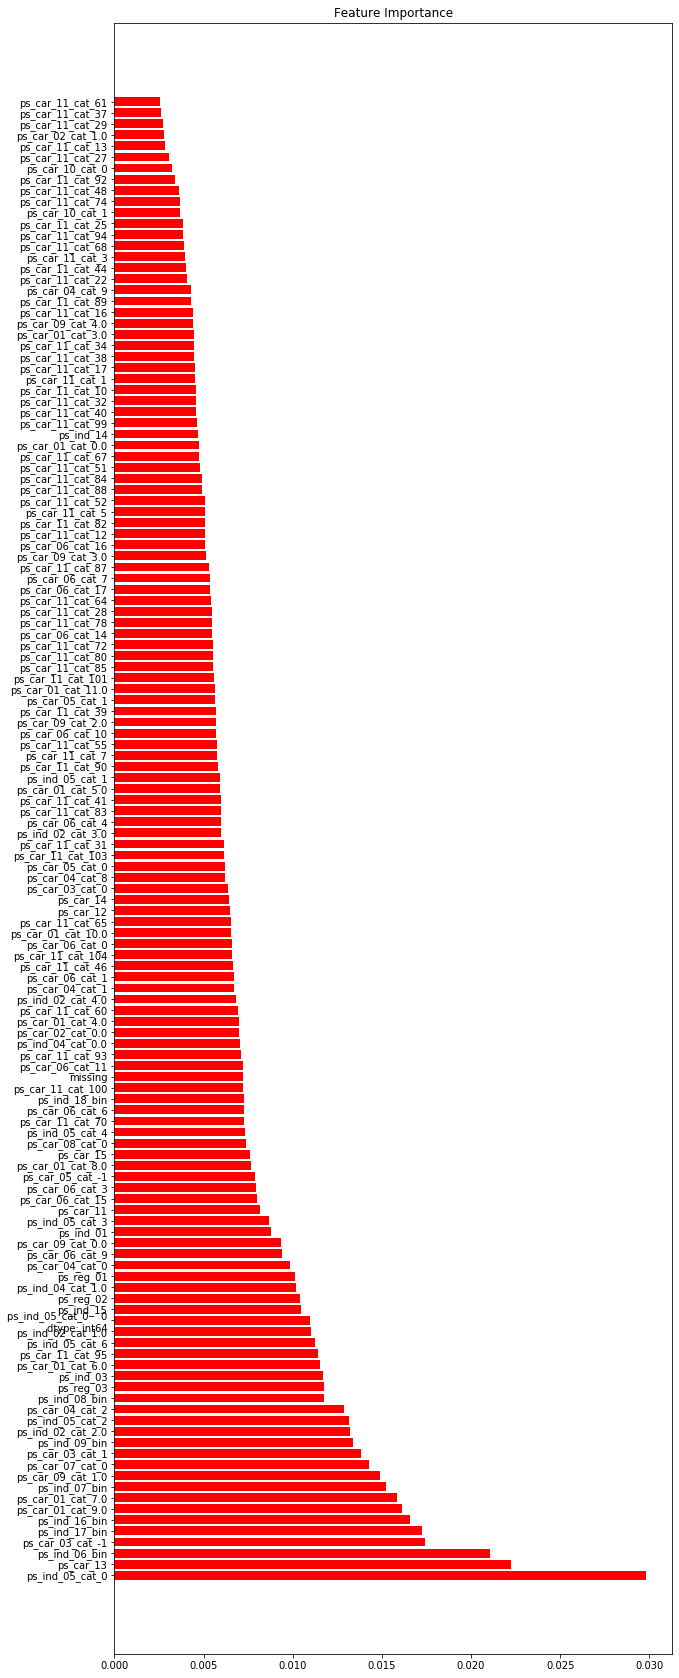

In [81]:
selected_features_xgb = feature_selection(xgb_model.feature_importances_, features, 0)

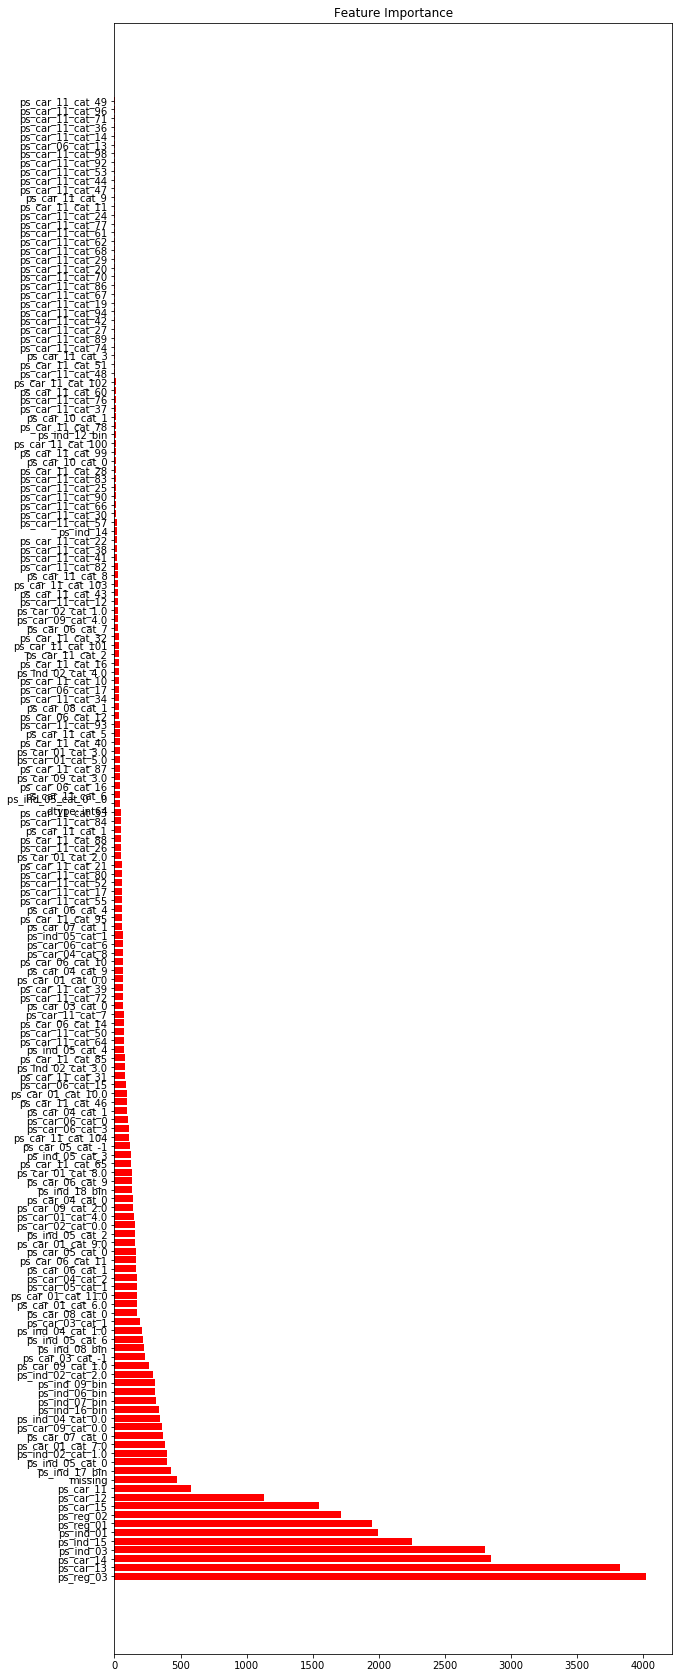

In [82]:
selected_features_lgb = feature_selection(lgb_model.feature_importances_, features, 0)

In [83]:
print("Total number of features selected by LightGBM :",len(selected_features_lgb)) 
print("Total number of features selected by XGBoost :",len(selected_features_xgb))

Total number of features selected by LightGBM : 169
Total number of features selected by XGBoost : 134


There seems to be a few features whose importance equals 0. Such features are removed.

<b> The final result was produced by a stack of two base models(1 xgboost + 1 lightgbm) and LogisticRegression as the meta_classifier.</b> 

## Stack

In [84]:
# The idea of this class implementation of a stack is taken from one of the kaggle kernels. This implementation was chosen over
# a library because it allows for more customization of the model.

# The stack is of two base models(1 xgb + 1 lgb), with a subset of different features used for each of them.
class Ensemble(object):
    def __init__(self, n_splits, meta_classifier, base_models, f_lgb, f_xgb):
        self.n_splits = n_splits
        self.meta_classifier = meta_classifier
        self.base_models = base_models
        self.f_lgb = f_lgb
        self.f_xgb = f_xgb

    def fit_predict(self, X, y, T):
         
        folds = list(StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=2016).split(X, y))
        
        S_train = np.zeros((X.shape[0], len(self.base_models)))
        S_test = np.zeros((T.shape[0], len(self.base_models)))
      
        for i, clf in enumerate(self.base_models):
            if i == 0:
                X_new = X[self.f_lgb]
                T_new = T[self.f_lgb]
            else:
                X_new = X[self.f_xgb]
                T_new = T[self.f_xgb]
            print('Fitting {}'.format(str(clf).split('(')[0]))         
                
            S_test_i = np.zeros((T.shape[0], self.n_splits))

            for j, (train_idx, test_idx) in enumerate(folds):
                X_train = X_new.iloc[train_idx,:]
                y_train = y.iloc[train_idx]
                X_holdout = X_new.iloc[test_idx,:] 
                
                clf.fit(X_train.values, y_train.values)

                y_pred = clf.predict_proba(X_holdout.values)[:,1]                

                S_train[test_idx, i] = y_pred
                S_test_i[:, j] = clf.predict_proba(T_new.values)[:,1]
           
            S_test[:, i] = S_test_i.mean(axis=1)

        results = cross_val_score(self.meta_classifier, S_train, y, cv=3, scoring='roc_auc')
        print("Stacker score: %.5f" % (results.mean()))

        self.meta_classifier.fit(S_train, y)
        res = self.meta_classifier.predict_proba(S_test)[:,1]
        return res, S_train, S_test

In [85]:
meta_classifier = LogisticRegression()
stack = Ensemble(5, meta_classifier, (lgb_model, xgb_model), selected_features_lgb, selected_features_xgb)
pred_test, S_train, S_test = stack.fit_predict(X_train, y_train, X_cv)

Fitting LGBMClassifier
Fitting XGBClassifier
Stacker score: 0.64238


In [86]:
gini_normalized(y_cv, pred_test)

0.2925219732882974

## Kaggle Test

In [87]:
meta_classifier = LogisticRegression()
stack = Ensemble(5, meta_classifier, (lgb_model, xgb_model), selected_features_lgb, selected_features_xgb)
pred_test, S_train, S_test = stack.fit_predict(train_ohe, y, test_ohe)

Fitting LGBMClassifier
Fitting XGBClassifier
Stacker score: 0.64364


In [88]:
submission = pd.DataFrame()
submission['id'] = test_id
submission['target'] = pred_test
submission.to_csv('final_predictions.csv', index = False)

# <center>SUMMARY

In [89]:
summary = pd.DataFrame()
summary['Models'] = ['XGBoost + OHE + Feature_Selection', 'LightGBM + OHE + Feature_Selection', 'Custom_Stack']
summary['Public_Score'] = [0.28275, 0.28346, 0.28473]
summary['Private_Score'] = [0.28976, 0.29053, 0.29115]
summary

,Models,Public_Score,Private_Score
0,XGBoost + OHE + Feature_Selection,0.28275,0.28976
1,LightGBM + OHE + Feature_Selection,0.28346,0.29053
2,Custom_Stack,0.28473,0.29115


1. Along with the above models, other models such as logistic regression, random forests, SVMs were also tried which proved to be ineffective for this problem.
2. Different categorical encodings like target encoding, frequency encoding, label encoding were also tried in combination. Although target encoding looked promising in the beginning, One Hot Encoding produced the best result.
3. The separate feature selections for the 2 base models further improved the score. 
3. This solution gets you into the top 1% of the competition leaderboard with an exact rank of 32.